# PROJECT KAYAK - API, SCRAPING & STORAGE

## **Project**
The marketing team needs help on a new project. After doing some user research, the team discovered that 70% of their users who are planning a trip would like to have more information about the destination they are going to.

In addition, user research shows that people tend to be defiant about the information they are reading if they don't know the brand which produced the content.

Therefore, Kayak Marketing Team would like to create an application that will recommend where people should plan their next holidays. The application should be based on real data about:

* Weather
* Hotels in the area


## **Goals**

The project aims to construct application that will be able to recommend the best destinations and hotels based on the above variables at any given time. To achieve this goal, the project will be structured into four main components:

1. **Get weather data from each destination using API**
2. **Scrape data from destinations and hotels using booking.com**
3. **Store all the information above in a data lake**
4. **Transform and load cleaned data for analysis**


In [1]:
# Library imports

import pandas as pd 
import requests 
import json
import time
import plotly.io as pio
import plotly.express as px
import boto3
import warnings
from sqlalchemy import create_engine
from sqlalchemy.sql import text
import psycopg2
warnings.filterwarnings("ignore")

In [2]:
# Marketing team wants to focus first on the best cities to travel to in France. According One Week In.com here are the top-35 cities to visit in France:

list1 = ["Mont Saint Michel",
"St Malo",
"Bayeux",
"Le Havre",
"Rouen",
"Paris",
"Amiens",
"Lille",
"Strasbourg",
"Chateau du Haut Koenigsbourg",
"Colmar",
"Eguisheim",
"Besancon",
"Dijon",
"Annecy",
"Grenoble",
"Lyon",
"Gorges du Verdon",
"Bormes les Mimosas",
"Cassis",
"Marseille",
"Aix en Provence",
"Avignon",
"Uzes",
"Nimes",
"Aigues Mortes",
"Saintes Maries de la mer",
"Collioure",
"Carcassonne",
"Ariege",
"Toulouse",
"Montauban",
"Biarritz",
"Bayonne",
"La Rochelle"]

### 1. Get weather data from each destination using API

a) Get Latitude and Longitude for each cities

In [3]:
# request the API  https://nominatim.org/  to have latitude and longitude for each cities
r=[]
for el in list1 :
    para = {
		"city": el,
		"country": "France",
		"format" : "json",
        "limit" : 1 #One result per city
	}
    r.extend(requests.get("https://nominatim.openstreetmap.org/search?", params=para).json())
    
print ("Result of the request:")
print (r) 

Result of the request:
[{'place_id': 247828266, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 211285890, 'lat': '48.6359541', 'lon': '-1.511459954959514', 'class': 'place', 'type': 'islet', 'place_rank': 20, 'importance': 0.45543655678157396, 'addresstype': 'islet', 'name': 'Mont Saint-Michel', 'display_name': 'Mont Saint-Michel, Le Mont-Saint-Michel, Avranches, Manche, Normandie, France métropolitaine, 50170, France', 'boundingbox': ['48.6349172', '48.6370310', '-1.5133292', '-1.5094796']}, {'place_id': 247779061, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 905534, 'lat': '48.649518', 'lon': '-2.0260409', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5764672172428952, 'addresstype': 'town', 'name': 'Saint-Malo', 'display_name': 'Saint-Malo, Ille-et-Vilaine, Bretagne, France métropolitaine, 35400, France', 'bound

In [61]:
# Build a list with only name, lat et long.
ville_lat_lon = []
for i in range (len(r)) :
    dic= {
        "name" : r[i]['name'],
        "lat" : r[i]['lat'],
        "lon" : r[i]['lon']
    }
    ville_lat_lon.append(dic)
ville_lat_lon

[{'name': 'Mont Saint-Michel',
  'lat': '48.6359541',
  'lon': '-1.511459954959514'},
 {'name': 'Saint-Malo', 'lat': '48.649518', 'lon': '-2.0260409'},
 {'name': 'Bayeux', 'lat': '49.2764624', 'lon': '-0.7024738'},
 {'name': 'Le Havre', 'lat': '49.4938975', 'lon': '0.1079732'},
 {'name': 'Rouen', 'lat': '49.4404591', 'lon': '1.0939658'},
 {'name': 'Paris', 'lat': '48.8534951', 'lon': '2.3483915'},
 {'name': 'Amiens', 'lat': '49.8941708', 'lon': '2.2956951'},
 {'name': 'Lille', 'lat': '50.6365654', 'lon': '3.0635282'},
 {'name': 'Strasbourg', 'lat': '48.584614', 'lon': '7.7507127'},
 {'name': 'Château du Haut-Kœnigsbourg',
  'lat': '48.2495226',
  'lon': '7.3454923'},
 {'name': 'Colmar', 'lat': '48.0777517', 'lon': '7.3579641'},
 {'name': 'Eguisheim', 'lat': '48.0447968', 'lon': '7.3079618'},
 {'name': 'Besançon', 'lat': '47.2380222', 'lon': '6.0243622'},
 {'name': 'Dijon', 'lat': '47.3215806', 'lon': '5.0414701'},
 {'name': 'Annecy', 'lat': '45.8992348', 'lon': '6.1288847'},
 {'name': 

In [62]:
# Transform dic into DataFrame
df = pd.DataFrame(ville_lat_lon)
df["id"]=df.index
df.head()

,name,lat,lon,id
0,Mont Saint-Michel,48.6359541,-1.511459954959514,0
1,Saint-Malo,48.649518,-2.0260409,1
2,Bayeux,49.2764624,-0.7024738,2
3,Le Havre,49.4938975,0.1079732,3
4,Rouen,49.4404591,1.0939658,4


b) Get weather for each cities

In [63]:
# Get weather from https://openweathermap.org/appid
meteo_forcast = []
for ville in ville_lat_lon:  
	para = {
		"lat": ville["lat"],
		"lon": ville["lon"],
		"appid" : "ENTER_YOUR_KEY", # This ID can be find on your oppenweathermap API account
        "mode" : "json",
        "units" : "metric",
	}
	meteo_forcast.append(requests.get("https://api.openweathermap.org/data/2.5/forecast?", params=para).json())
meteo_forcast

[{'cod': '200',
  'message': 0,
  'cnt': 40,
  'list': [{'dt': 1706724000,
    'main': {'temp': 11.63,
     'feels_like': 10.94,
     'temp_min': 10.1,
     'temp_max': 11.63,
     'pressure': 1032,
     'sea_level': 1032,
     'grnd_level': 1033,
     'humidity': 80,
     'temp_kf': 1.53},
    'weather': [{'id': 802,
      'main': 'Clouds',
      'description': 'scattered clouds',
      'icon': '03n'}],
    'clouds': {'all': 46},
    'wind': {'speed': 3.91, 'deg': 209, 'gust': 8.35},
    'visibility': 10000,
    'pop': 0,
    'sys': {'pod': 'n'},
    'dt_txt': '2024-01-31 18:00:00'},
   {'dt': 1706734800,
    'main': {'temp': 10.5,
     'feels_like': 9.88,
     'temp_min': 9.56,
     'temp_max': 10.5,
     'pressure': 1032,
     'sea_level': 1032,
     'grnd_level': 1033,
     'humidity': 87,
     'temp_kf': 0.94},
    'weather': [{'id': 803,
      'main': 'Clouds',
      'description': 'broken clouds',
      'icon': '04n'}],
    'clouds': {'all': 79},
    'wind': {'speed': 5.3, 'deg'

In [64]:
# Create DataFrame with humidity and temperature values coming from the weather API. 

list_des_eles = []
for i in range(len(meteo_forcast)): 
    for j in  range(len(meteo_forcast[i]["list"])): 
        d1 = meteo_forcast[i]["list"][j]["main"]
        d2 =  {"date" : meteo_forcast[i]["list"][j]["dt"]}
        d3 = {"city" : meteo_forcast[i]["city"]['name']}
        d4 = d1 | d2 | d3
        list_des_eles = list_des_eles + list([d4])

df_meteo= pd.DataFrame(list_des_eles)

df_meteo.head()

,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,temp_kf,date,city
0,11.63,10.94,10.10,11.63,1032,1032,1033,80,1.53,1706724000,Huisnes-sur-Mer
1,10.50,9.88,9.56,10.50,1032,1032,1033,87,0.94,1706734800,Huisnes-sur-Mer
2,9.06,6.83,9.06,9.06,1034,1034,1034,94,0.00,1706745600,Huisnes-sur-Mer
3,8.49,6.25,8.49,8.49,1033,1033,1033,96,0.00,1706756400,Huisnes-sur-Mer
4,9.42,7.37,9.42,9.42,1034,1034,1034,97,0.00,1706767200,Huisnes-sur-Mer


In [65]:
# Get the weather forecast for three days and beyond (allowing time for decision-making).

mask=df_meteo["date"]> (int(time.time()) + 3 * 24 * 60 * 60)
df_meteo = df_meteo[mask]

# Group by cities and add average. 

df_meteo_group_by = df_meteo.groupby(df_meteo["city"], sort=False, as_index=False).mean() 

df_meteo_group_by.head()

,city,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,temp_kf,date
0,Huisnes-sur-Mer,9.178750,8.200625,9.178750,9.178750,1031.7500,1031.7500,1031.7500,90.4375,0.0,1.707064e+09
1,St-Malo,9.586875,7.992500,9.586875,9.586875,1031.6250,1031.6250,1029.6250,88.6875,0.0,1.707064e+09
2,Bayeux,9.762500,7.543125,9.762500,9.762500,1030.5625,1030.5625,1024.5000,90.6250,0.0,1.707064e+09
3,Le Havre,9.384375,6.962500,9.384375,9.384375,1030.3125,1030.3125,1029.0000,91.7500,0.0,1.707064e+09
4,Rouen,9.643750,7.739375,9.643750,9.643750,1030.1250,1030.1250,1027.4375,90.6250,0.0,1.707064e+09


It appears that for certain cities, the GPS coordinates considered in the API correspond to a city very close to those in the first list but not the same city. As we will need the more precise names of the cities for hotel search, we will identify the differences and replace the values. This is not an error; the weather forecasts remain usable.

In [66]:
# Comparison
df_meteo_group_by["city"].compare(df["name"])

,self,other
0,Huisnes-sur-Mer,Mont Saint-Michel
1,St-Malo,Saint-Malo
8,Arrondissement de Strasbourg,Strasbourg
9,Saint-Hippolyte,Château du Haut-Kœnigsbourg
13,Larrey,Dijon
16,Vieux Lyon,Lyon
17,Bauduen,Gorges du Verdon
29,Foix,Ariège


In [67]:
# city cleaning 
for i in range(len(df["name"])) :
    if  df_meteo_group_by["city"].iloc[i] != df["name"].iloc[i] :
        df_meteo_group_by["city"].iloc[i] = df["name"].iloc[i]

df_meteo_group_by["lat"]=df["lat"].astype(float)
df_meteo_group_by["lon"]=df["lon"].astype(float)
df_meteo_group_by

,city,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,temp_kf,date,lat,lon
0,Mont Saint-Michel,9.178750,8.200625,9.178750,9.178750,1031.7500,1031.7500,1031.7500,90.4375,0.0,1.707064e+09,48.635954,-1.511460
1,Saint-Malo,9.586875,7.992500,9.586875,9.586875,1031.6250,1031.6250,1029.6250,88.6875,0.0,1.707064e+09,48.649518,-2.026041
2,Bayeux,9.762500,7.543125,9.762500,9.762500,1030.5625,1030.5625,1024.5000,90.6250,0.0,1.707064e+09,49.276462,-0.702474
3,Le Havre,9.384375,6.962500,9.384375,9.384375,1030.3125,1030.3125,1029.0000,91.7500,0.0,1.707064e+09,49.493898,0.107973
4,Rouen,9.643750,7.739375,9.643750,9.643750,1030.1250,1030.1250,1027.4375,90.6250,0.0,1.707064e+09,49.440459,1.093966
5,Paris,9.610000,8.460000,9.610000,9.610000,1030.7500,1030.7500,1025.9375,85.8750,0.0,1.707064e+09,48.853495,2.348391
6,Amiens,10.075000,8.073750,10.075000,10.075000,1029.0000,1029.0000,1025.0000,87.3750,0.0,1.707064e+09,49.894171,2.295695
7,Lille,10.218750,8.422500,10.218750,10.218750,1027.0000,1027.0000,1023.3750,86.5000,0.0,1.707064e+09,50.636565,3.063528
8,Strasbourg,8.983125,7.329375,8.983125,8.983125,1030.2500,1030.2500,1011.8125,81.9375,0.0,1.707064e+09,48.584614,7.750713
9,Château du Haut-Kœnigsbourg,6.384375,5.030625,6.384375,6.384375,1030.6875,1030.6875,951.1250,83.3125,0.0,1.707064e+09,48.249523,7.345492


In [68]:
# Save CSV file
df_meteo_group_by.to_csv("df_meteo.csv")

In [7]:
df_meteo = pd.read_csv('df_meteo.csv')

c) Weather visualization

In [8]:
# Representation of these cities on a map with temperature in colour and humidity in size
fig = px.scatter_mapbox(df_meteo, lat="lat", lon="lon", color='temp', size="humidity", hover_name="city", height=900, width= 900,
                     color_continuous_scale = "YlOrRd", zoom=5, mapbox_style="carto-positron")
fig.show()

### 2. Scrape data from destinations and hotels using booking.com

In [94]:
# Scrapping using file booking.py

! python src/booking.py
file = open("src/hotels.json")
file = json.load(file)
print (file)

2024-02-02 12:48:26 [scrapy.utils.log] INFO: Scrapy 2.8.0 started (bot: scrapybot)
2024-02-02 12:48:26 [scrapy.utils.log] INFO: Versions: lxml 4.9.2.0, libxml2 2.10.3, cssselect 1.1.0, parsel 1.6.0, w3lib 1.21.0, Twisted 22.10.0, Python 3.11.4 (main, Jul  5 2023, 08:54:11) [Clang 14.0.6 ], pyOpenSSL 23.2.0 (OpenSSL 1.1.1w  11 Sep 2023), cryptography 41.0.2, Platform macOS-14.1.2-arm64-arm-64bit
2024-02-02 12:48:26 [scrapy.crawler] INFO: Overridden settings:
{'AUTOTHROTTLE_ENABLED': True,
 'COOKIES_ENABLED': False,
 'DOWNLOAD_DELAY': 5,
 'LOG_LEVEL': 20,
 'USER_AGENT': 'Chrome/120.0.0.0'}
2024-02-02 12:48:26 [py.warnings] WARNING: /Users/simoncld/anaconda3/lib/python3.11/site-packages/scrapy/utils/request.py:232: ScrapyDeprecationWarning: '2.6' is a deprecated value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting.

It is also the default value. In other words, it is normal to get this warning if you have not defined a value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting. 

In [4]:
#Let's see what is in the file obtained. 
df_hotels = pd.read_json('src/hotels.json')
df_hotels.head()

,Address,ville,name,description,latlong,note,url
0,"\ngrande rue, 50170 Le Mont-Saint-Michel, Fran...",Mont Saint Michel,Hôtel la Croix Blanche,Situé au cœur du village médiéval du Mont-Sain...,"48.63573406,-1.50986105","7,8",https://www.booking.com/hotel/fr/ha-el-la-croi...
1,"\n9 rue des terres - Place Charles de Gaulle, ...",Bayeux,Le Petit Matin,Cette maison d'hôtes occupe un bâtiment du XVI...,"49.27606133,-0.70905536","9,3",https://www.booking.com/hotel/fr/le-petit-mati...
2,"\nLe Haut Salmon, 35400 Saint-Malo, France\n",St Malo,Chambres d'Hôtes du Manoir du Haut Salmon,Située à seulement 10 minutes en voiture des p...,"48.63320639,-1.95942342","8,0",https://www.booking.com/hotel/fr/manoir-du-hau...
3,"\n4 Rue De La Savonnerie, 76000 Rouen, France\n",Rouen,"The Originals City, Hôtel Notre Dame, Rouen","L’établissement The Originals City, Hôtel Notr...","49.43853490,1.09345078","7,3",https://www.booking.com/hotel/fr/hotel-notre-d...
4,"\n1 Rue Louis Philippe, Perret, 76600 Le Havre...",Le Havre,"The Originals Boutique, Hôtel d'Angleterre, Le...",Le Boutique Hotel d’Angleterre Le Havre se tro...,"49.49404915,0.09936646","7,5",https://www.booking.com/hotel/fr/comfort-d-ang...


In [5]:
df_hotels.describe()

,Address,ville,name,description,latlong,note,url
count,558,558,558,558,558,546,558
unique,550,35,558,558,555,36,558
top,"\n4 Rue Saint-Maurice, 74000 Annecy, France\n",Bayonne,Hôtel la Croix Blanche,Situé au cœur du village médiéval du Mont-Sain...,"45.89907460,6.12814620","8,3",https://www.booking.com/hotel/fr/ha-el-la-croi...
freq,2,24,1,1,2,39,1


Scrapping of Booking is done. We have now hotels in the all the best cities to travel to in France

### 3. Store all the information above in a data lake

In [12]:
bucket_name = 'your_bucket_name' #Change with your credentials
local_file_path = 'src/hotels.json' 
s3_file_key = 'Path_to_S3/hotels.json' #Change with your credentials
s3 = boto3.client('s3')
try:
    s3.upload_file(local_file_path, bucket_name, s3_file_key)
    print("File uploaded")
except FileNotFoundError:
    print("No such file in directory")
except Exception as e:
    print(f"error : {e}")

File uploaded


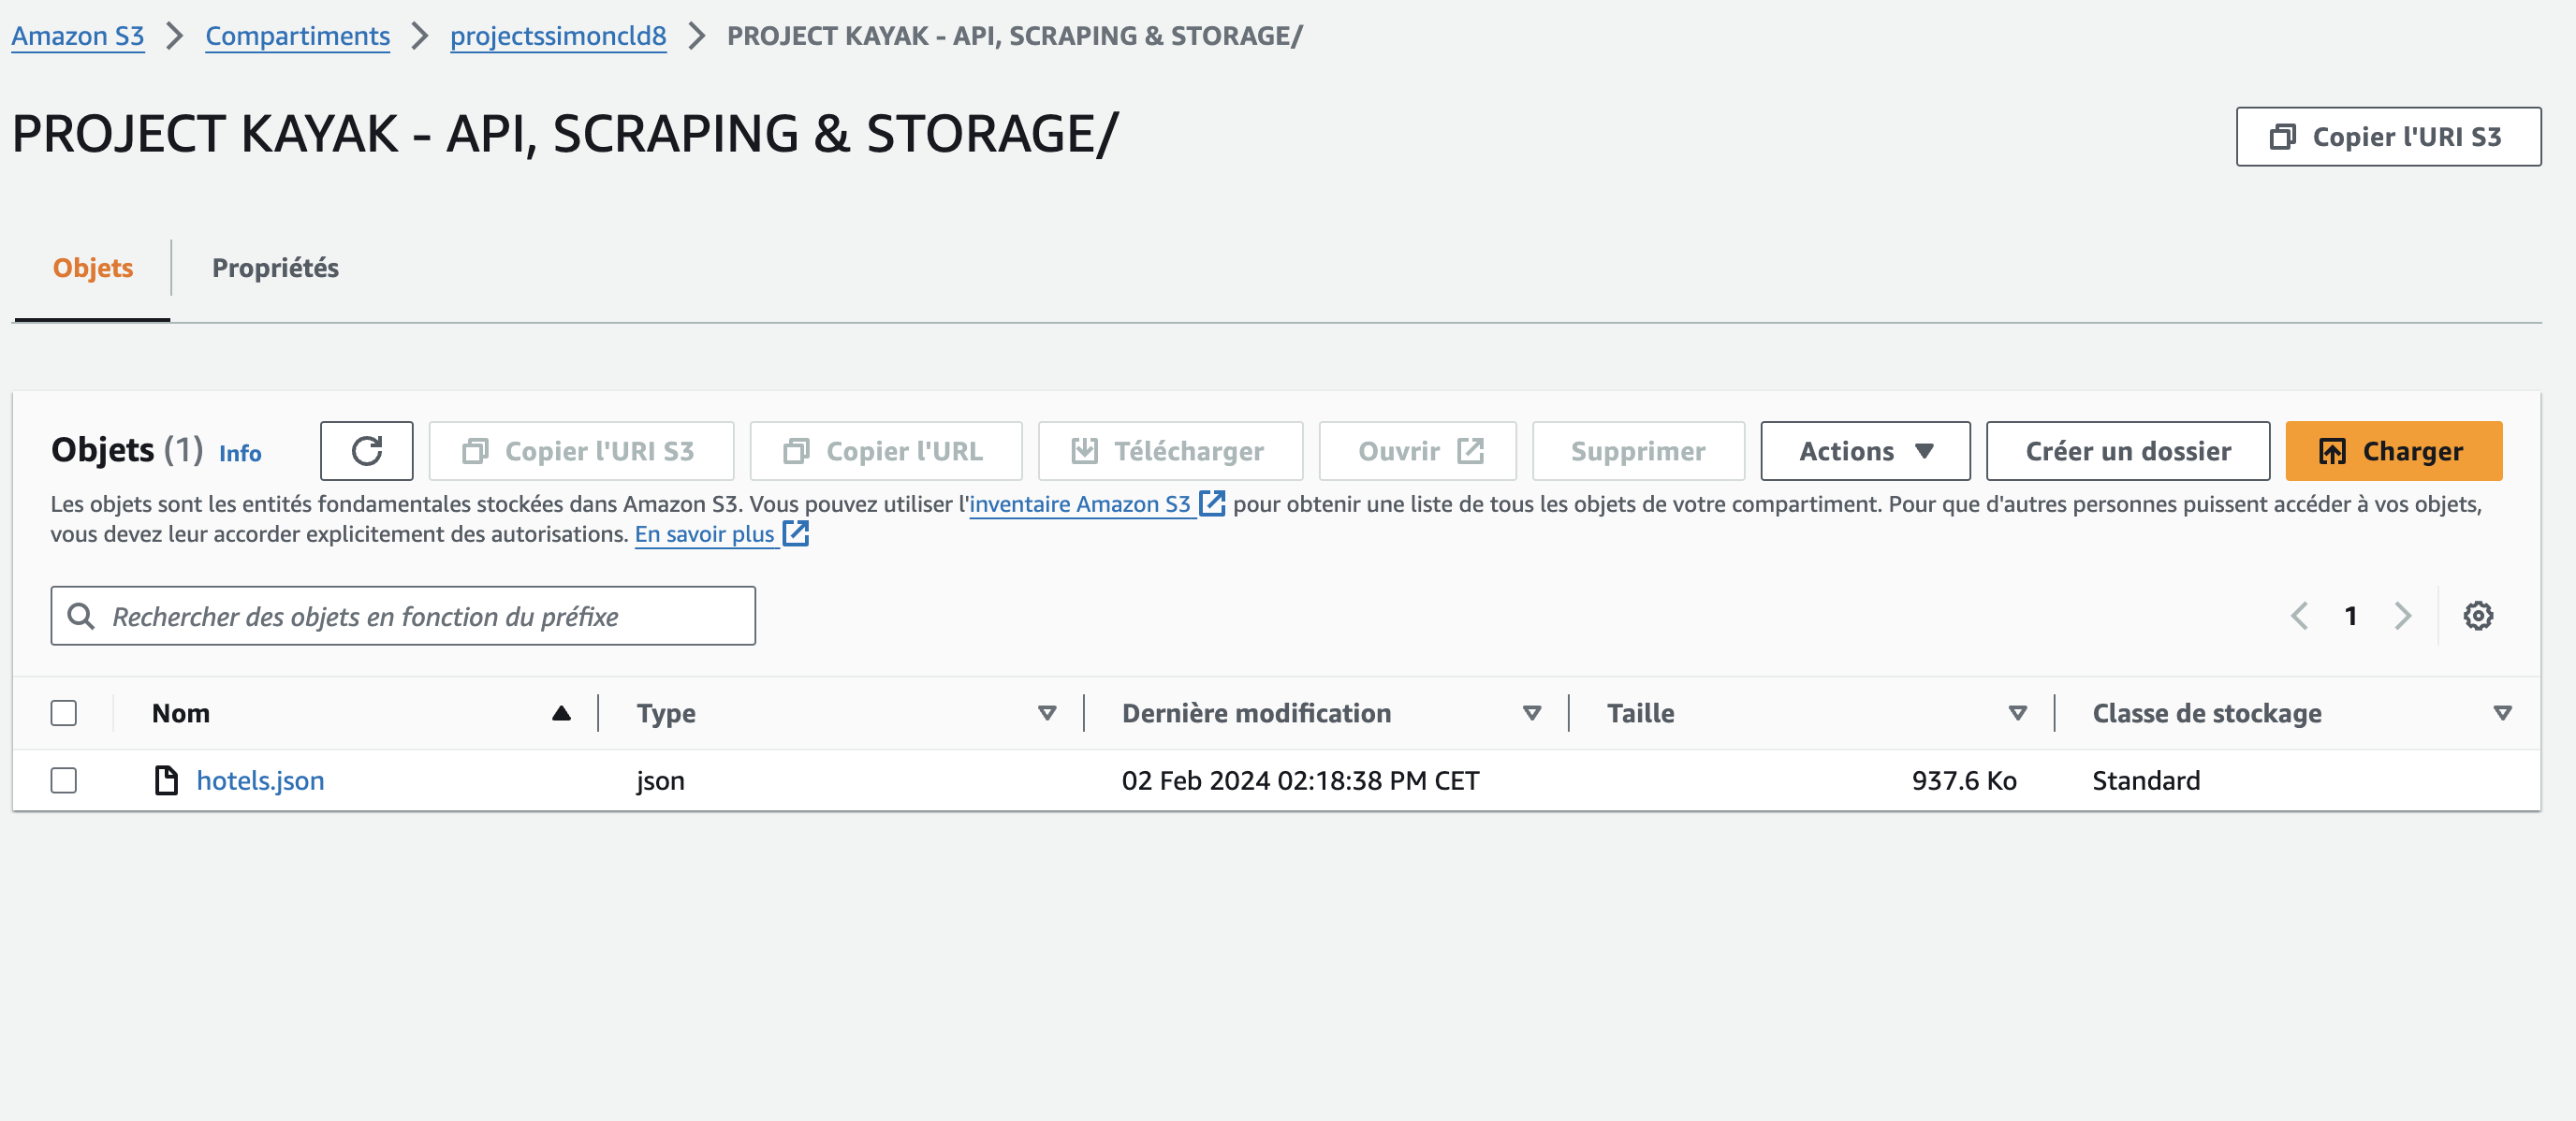

In [13]:
bucket_name = 'your_bucket_name' #Change with your credentials
local_file_path = 'df_meteo.csv' 
s3_file_key = 'Path_to_S3/df_meteo.csv' #Change with your credentials
s3 = boto3.client('s3')
try:
    s3.upload_file(local_file_path, bucket_name, s3_file_key)
    print("File uploaded")
except FileNotFoundError:
    print("No such file in directory")
except Exception as e:
    print(f"error : {e}")

File uploaded


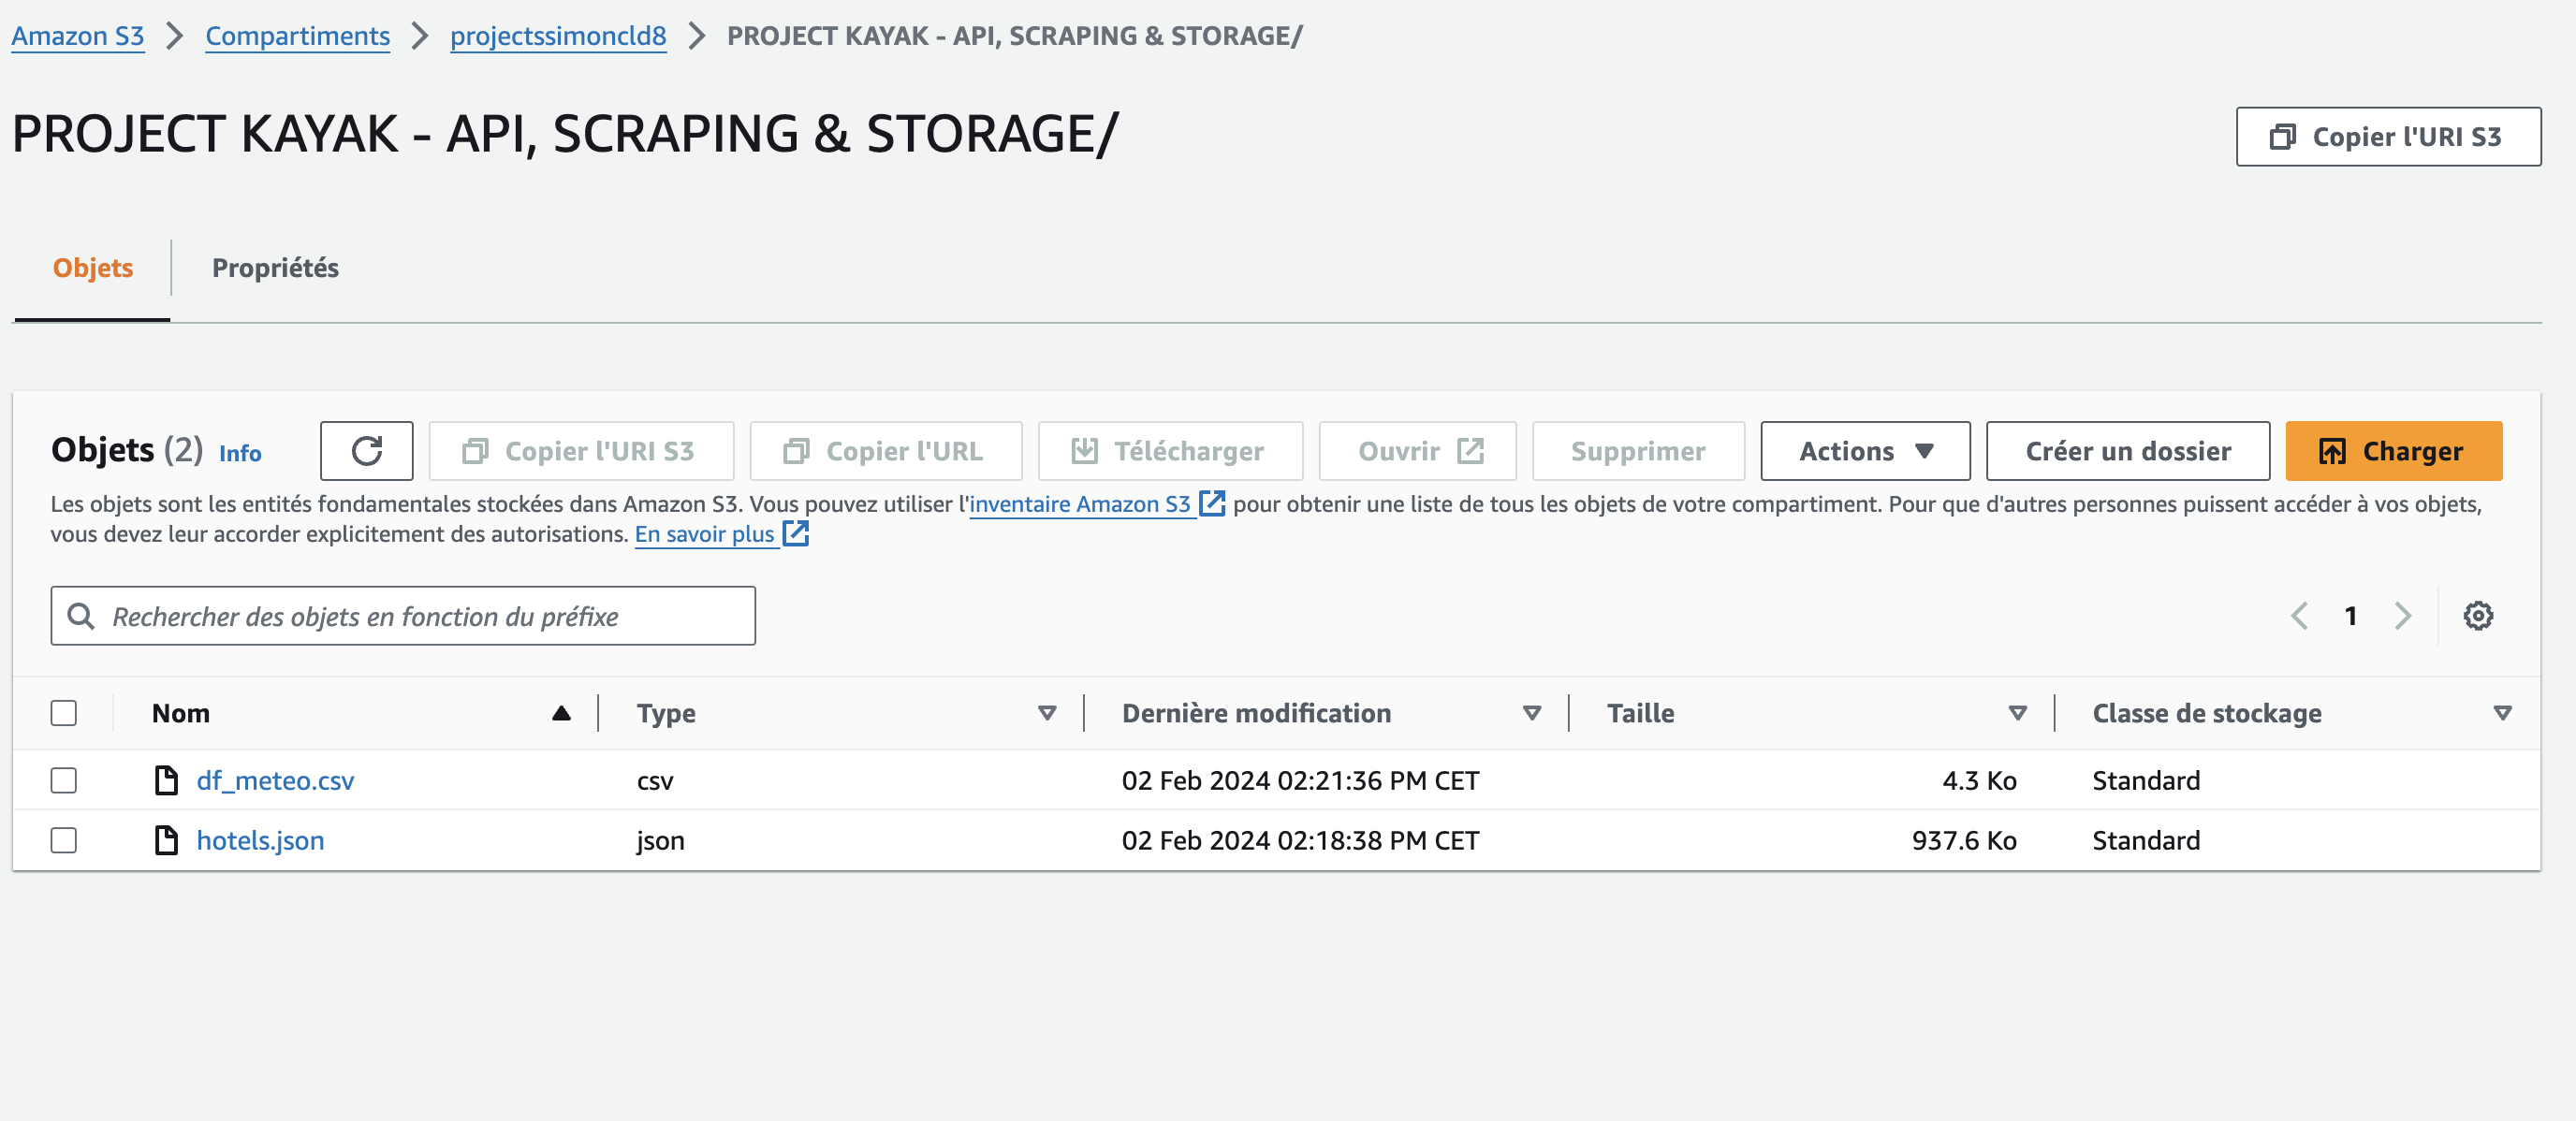

Our files are now in a S3 bucket.

### 4. Transform and load cleaned data for analysis

In [9]:
# Connexion to RDS instance

username = 'postgres' #Change with your credentials
password = 'password' #Change with your credentials
host = 'RDS_INSTANCE_ENDPOINT' #Change with your credentials
port = '5432' #Change with your credentials

# Connexion URL
db_url = f'postgresql+psycopg2://{username}:{password}@{host}:{port}/postgres'

# Create connexion
engine = create_engine(db_url, echo=True)

AWS RDS instance was created : 

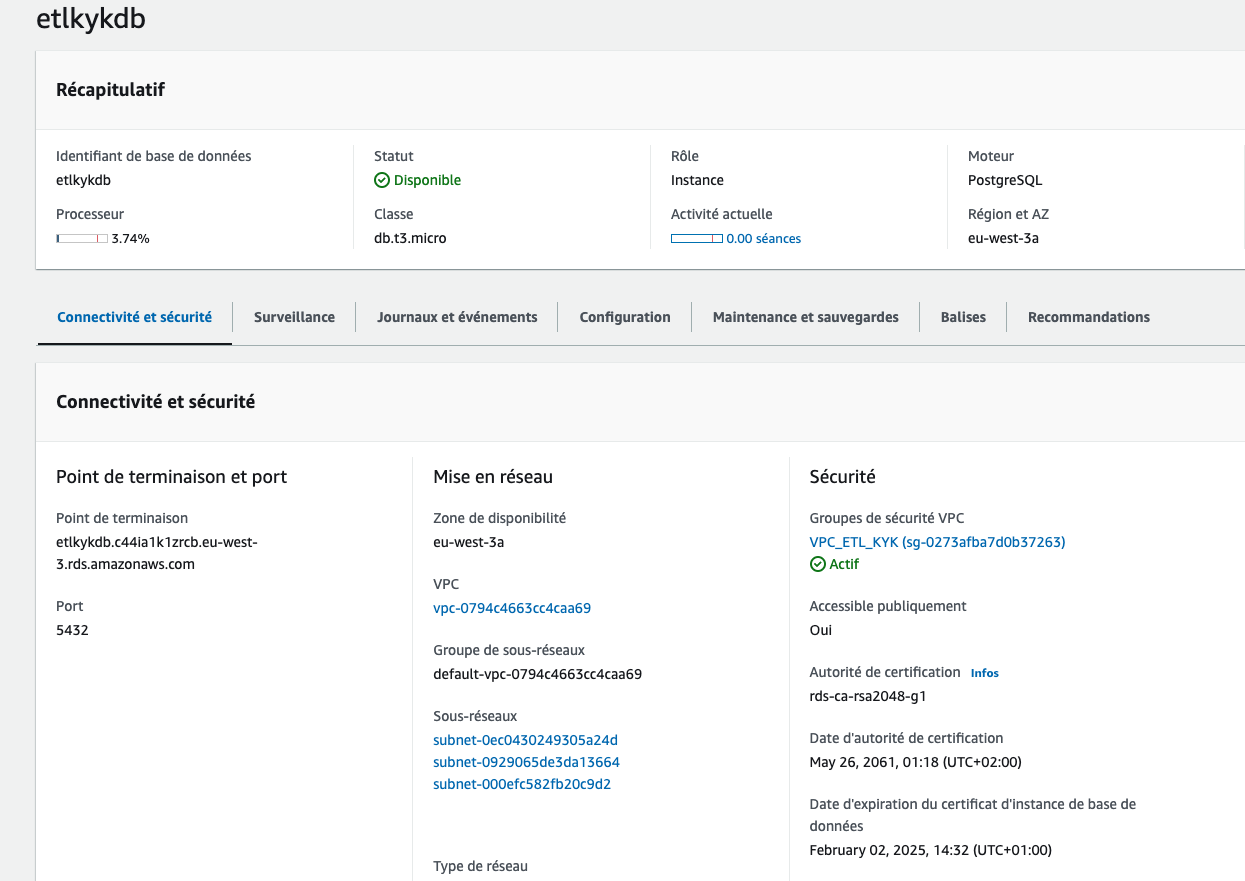

In [7]:
#Read files from S3
df_hotels_S3 = pd.read_json('Path_to_S3/hotels.json')
df_meteo_S3 = pd.read_csv('Path_to_S3/df_meteo.csv')

In [10]:
# Cretation of tables 
table_name_1 = 'hotels'
table_name_2 = 'meteo'
df_hotels_S3.to_sql(table_name_1, engine, index=False, if_exists='replace')
df_meteo_S3.to_sql(table_name_2, engine, index=False, if_exists='replace')

2024-02-03 14:49:35,318 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2024-02-03 14:49:35,319 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-02-03 14:49:35,368 INFO sqlalchemy.engine.Engine select current_schema()
2024-02-03 14:49:35,369 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-02-03 14:49:35,425 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2024-02-03 14:49:35,426 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-02-03 14:49:35,474 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-02-03 14:49:35,478 INFO sqlalchemy.engine.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2024-02-03 14:49:35,478 INFO sqlalchemy.engine.Engine [generated in 0.00052s] {'name': 'hotels'}
2024-02-03 14:49:35,533 INFO sqlalchemy.engine.Engine 
CREATE TABLE hotels (
	"Address" TEXT, 
	ville TEXT, 
	name TEXT, 
	description TEXT, 
	latlong TEXT, 
	note TEXT, 
	url TEXT
)


2024-

35

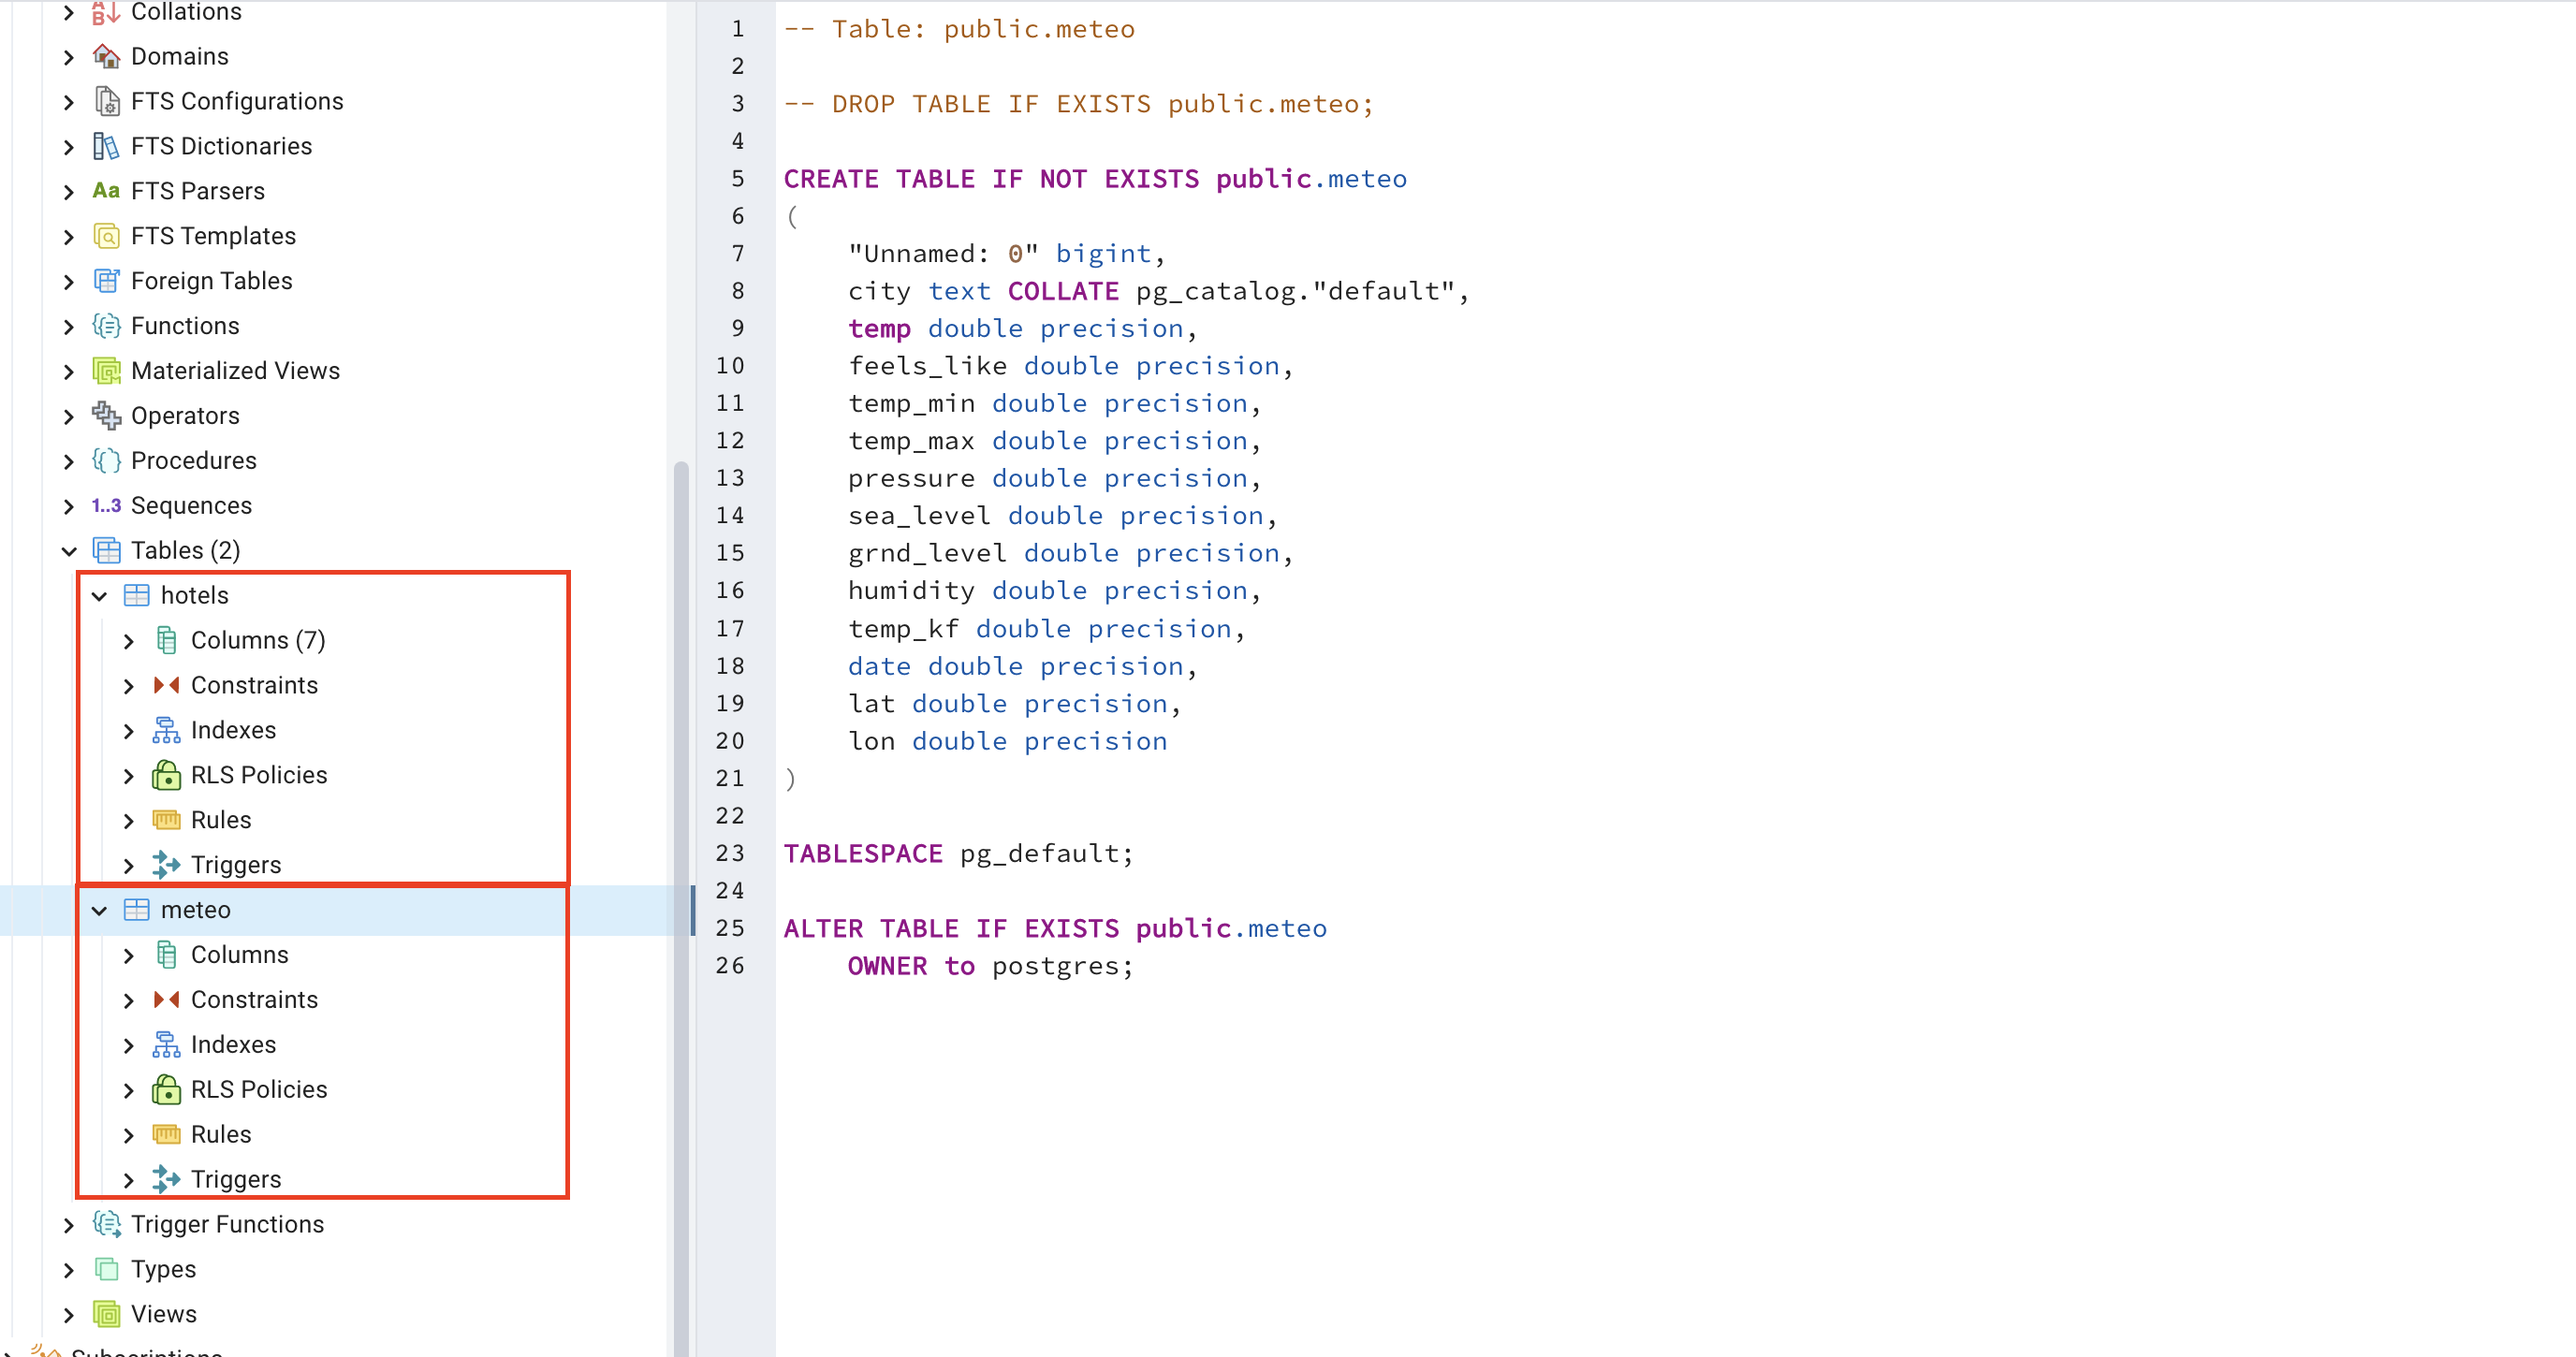

Now, the two tables are created. We can use them with SQL request to do some analysis. 

In [90]:
# Query top 3 city by weather - Warm
sql_query = """
SELECT city, temp, humidity, lat, lon
FROM meteo
ORDER BY temp DESC, humidity ASC
LIMIT 3;
"""

top_meteo_cities_df = pd.read_sql_query(sql_query, engine)

top_meteo_cities_df.head()

2024-02-03 15:59:38,073 INFO sqlalchemy.engine.Engine 
SELECT city, temp, humidity, lat, lon
FROM meteo
ORDER BY temp DESC, humidity ASC
LIMIT 3;

2024-02-03 15:59:38,073 INFO sqlalchemy.engine.Engine [raw sql] {}


,city,temp,humidity,lat,lon
0,Collioure,14.320625,53.6875,42.525050,3.083155
1,Marseille,12.235000,65.6875,43.296174,5.369953
2,Cassis,12.058125,66.8750,43.214036,5.539632


In [91]:
fig = px.scatter_mapbox(top_meteo_cities_df, lat="lat", lon="lon", color='temp', size="humidity", hover_name="city", height=900, width= 900,
                     color_continuous_scale = "YlOrRd", zoom=5, mapbox_style="carto-positron")
fig.show()

In [102]:
# Query top 5 hotels per city

top_hotels_dfs=pd.DataFrame()

for city in top_meteo_cities_df['city']:
    hotel_query = f"""
    SELECT 
        ville,
        name,
        latlong,
        description,
        note,
        url
    FROM hotels
    WHERE ville = '{city}'
    ORDER BY note DESC
    LIMIT 5;
    """
    top_hotels_dfs = pd.concat([top_hotels_dfs, pd.read_sql_query(hotel_query, engine)])

    top_hotels_dfs.head()

2024-02-03 16:00:25,302 INFO sqlalchemy.engine.Engine 
    SELECT 
        ville,
        name,
        latlong,
        description,
        note,
        url
    FROM hotels
    WHERE ville = 'Collioure'
    ORDER BY note DESC
    LIMIT 5;
    
2024-02-03 16:00:25,303 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-02-03 16:00:25,369 INFO sqlalchemy.engine.Engine 
    SELECT 
        ville,
        name,
        latlong,
        description,
        note,
        url
    FROM hotels
    WHERE ville = 'Marseille'
    ORDER BY note DESC
    LIMIT 5;
    
2024-02-03 16:00:25,370 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-02-03 16:00:25,434 INFO sqlalchemy.engine.Engine 
    SELECT 
        ville,
        name,
        latlong,
        description,
        note,
        url
    FROM hotels
    WHERE ville = 'Cassis'
    ORDER BY note DESC
    LIMIT 5;
    
2024-02-03 16:00:25,435 INFO sqlalchemy.engine.Engine [raw sql] {}


In [103]:
#Split latlon into two columns 
top_hotels_dfs[['lat', 'lon']] = top_hotels_dfs['latlong'].str.split(',', expand=True)

# String to float for plot
top_hotels_dfs['lat'] = pd.to_numeric(top_hotels_dfs['lat'])
top_hotels_dfs['lon'] = pd.to_numeric(top_hotels_dfs['lon'])
top_hotels_dfs['note'] = top_hotels_dfs['note'].str.replace(',', '.').astype(float).fillna(0)

In [105]:
top_hotels_dfs['note'].fillna(0) #Some hotels do not have rating. We just put their value to 0

fig = px.scatter_mapbox(top_hotels_dfs, lat="lat", lon="lon", color='note', hover_name="name", height=900, width= 900,
                     color_continuous_scale = "YlOrRd", zoom=5, mapbox_style="carto-positron")
fig.show()